# T-tests are Linear Regression

## A new way to decide if your ideas are correct

# <span style='color:blue'> Part 1: T-tests </span> 

### A word problem

Adam emails Amber:

> I want to know if advertising our newest trail will increase its weekend usage.
> * For the next two months, count the number of people that use the trail each Saturday.
> * Then, create an advertising campaign promoting the trail for two weeks.
> * Finally, spend another two months counting usage each Saturday.
>
> If there are more people that use the trail **on average** after the campaign, we'll keep promoting it!

In [53]:
import numpy as np
import pandas as pd
np.random.seed(11)

no_advertising = np.random.normal(50, 5, 8).astype(int)
print(no_advertising)
print(int(no_advertising.mean()))

advertising = np.random.normal(40, 5, 8).astype(int)
advertising[-1] = 250

print(advertising)
print(int(advertising.mean()))

[58 48 47 36 49 48 47 51]
48
[ 42  34  35  37  43  42  33 250]
64


### Results

Amber does the study and finds that, on average:

* For the first 8 weeks, an average of 48 people use the trail each weekend.
* After the advertising, an average of 64 people use the trail each weekend.

_Should Adam continue funding the advertising?_

### What do we want to know?

Another way of asking this question is:

Do we have enough evidence to be confident that the advertising had a positive effect on trail usage?

Naively, we could say:

> 64 _feels_ way higher than 48. It's a 35% increase. The advertising seems like it's working.

It'd be nice if we could use a mathematical framework for taking the _feeling_ out of this statement.

### Digging a little deeper

Before we do any stats, let's take a deeper look at the numbers Amber collected:

In [54]:
df1 = pd.DataFrame.from_dict({"no_advertising": no_advertising, "advertising": advertising}, orient="index")
df1.index.name = "week"

In [55]:
df1

0   1   2   3   4   5   6    7
week                                           
no_advertising  58  48  47  36  49  48  47   51
advertising     42  34  35  37  43  42  33  250

What's the obvious issue here?

## Lesson 1

Averages alone are insufficient to conclude whether our advertising had an effect on trail use. 

### What if we remove the outlier?

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12.0, 8.0]
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['legend.title_fontsize'] = 28

colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

In [57]:
recs = []
for i in range(1, 9):
    recs.append((i, "advertising", advertising[i-1]))
    recs.append((i, "no_advertising", no_advertising[i-1]))
    
df1_1 = pd.DataFrame.from_records(recs)
df1_1.columns = ["week", "advertising", "count"]
df1_1

week     advertising  count
0      1     advertising     42
1      1  no_advertising     58
2      2     advertising     34
3      2  no_advertising     48
4      3     advertising     35
5      3  no_advertising     47
6      4     advertising     37
7      4  no_advertising     36
8      5     advertising     43
9      5  no_advertising     49
10     6     advertising     42
11     6  no_advertising     48
12     7     advertising     33
13     7  no_advertising     47
14     8     advertising    250
15     8  no_advertising     51

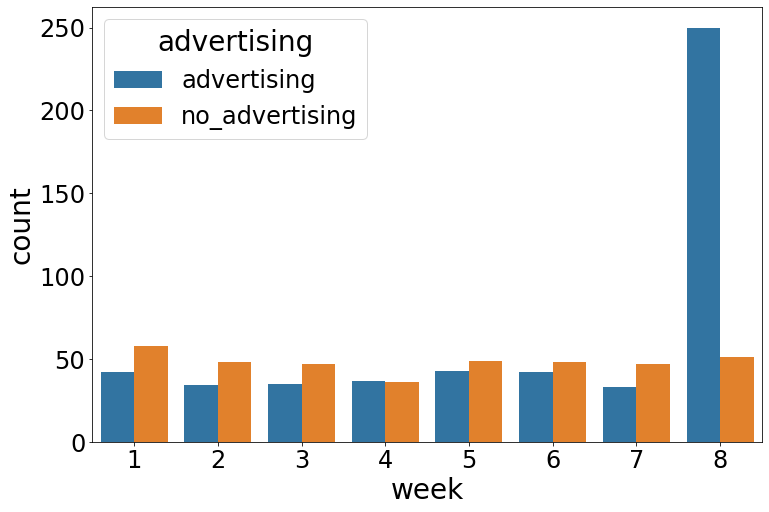

In [58]:
sns.barplot(x="week", y="count", hue="advertising", data=df1_1)
plt.show()

In [59]:
df1_1.at[14, "count"] = np.nan

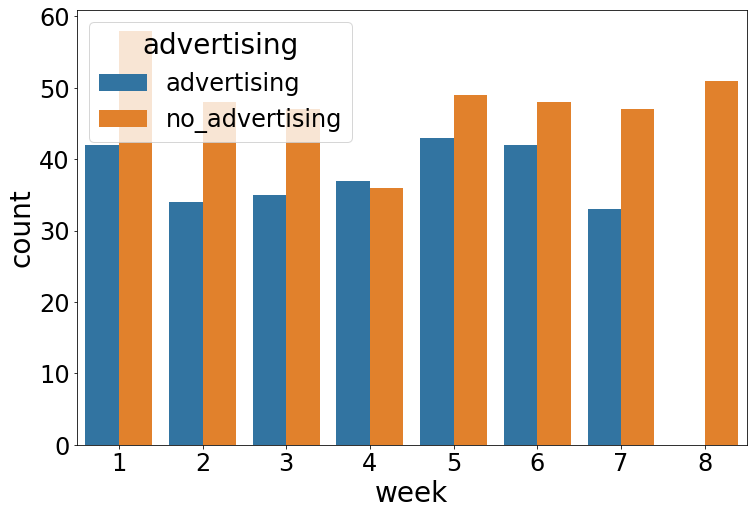

In [60]:
sns.barplot(x="week", y="count", hue="advertising", data=df1_1)
plt.show()

What just happened?!

If we remove the outlier, it looks like the advertising may actually _decreases_ the average trail usage. But we still haven't learned what math we need to convince ourselves that advertising had some effect. 

Besides the average, the other value we need to calculate about our data is the **variance**, or how spread out our numbers are. 

### Variance

* **x<sub>i</sub>** = The value of one sample
* **m** = The average of all samples in the group
* **n** = How many samples are in the group
* **V** = Variance

$$
V = \frac{\sum{(x_i - m)}^2}{n-1}
$$

### Example

Let's say we have a group, `[5, 10, 15]`:

$$
V = \frac{(5 - 10)^2 + (10 - 10)^2 + (15 - 10)^2}{3-1} = 25
$$

More data near the average gives us a lower variance:

In [61]:
G2 = [5, 10, 11, 12, 15]
V2 = ((5-10.6)**2 + (10-10.6)**2 + (11-10.6)**2 + (12-10.6)**2 + (15-10.6)**2)/(5-1)
print(f"The variance of {G2} is {V2}\n\n")

The variance of [5, 10, 11, 12, 15] is 13.3




In [62]:
def variance():
    a = np.random.normal(50, 5, 1000)
    b = np.random.normal(75, 10, 1000)
    c = np.random.normal(100, 20, 1000)
    sns.histplot(a, kde=True, color=colors[0], label=f"Children (V={int(a.var())})")
    sns.histplot(b, kde=True, color=colors[1], label=f"Women (V={int(b.var())})")
    sns.histplot(c, kde=True, color=colors[2], label=f"Men (V={int(c.var())})")
    plt.legend()
    plt.title("Phone Usage by Group (n=1000)")
    plt.xlabel("Time (mins)")

In [63]:
variance()

## Lesson 2

* The **average** gives us information about the _peaks_ of these groups. 
* The **variance** gives us information about the _widths_ of these groups.

### Student's t-test

A t-test allows you to compare two groups using their means and their variances to decide whether or not the averages of the two groups are the same.

$$
t = \frac{m_A - m_B}{\sqrt{ \frac{\frac{\sum{(x-m_A)^2}+\sum{(x-m_B)^2}}{n_A+n_B-2}}{n_A} + \frac{\frac{\sum{(x-m_A)^2}+\sum{(x-m_B)^2}}{n_A+n_B-2}}{n_B} }}
$$

In school, you're handed this formula and told to use it, with no real explanation of why it works.

### p-value

There's one more concept to learn about before we can decide if the average trail usage is different after advertising. It's a number called the `p-value`. 

* It's a decimal number between 0 and 1. 
* For our usage, the smaller the p-value, the more likely it is that the averages of the two groups are different, and thus more likely that the advertising had an effect.
* By convention, if the `p-value` is smaller than `0.05`, we say that the two groups have different averages. 

Running a `t-test` will give you a `p-value`.

### t-test usage

Let's tie all of these concepts together using Amber's data.

In [64]:
df1

0   1   2   3   4   5   6    7
week                                           
no_advertising  58  48  47  36  49  48  47   51
advertising     42  34  35  37  43  42  33  250

In [65]:
from scipy.stats import ttest_ind

In [66]:
round(ttest_ind(advertising, no_advertising, equal_var=False).pvalue, 4)

0.5548

This `p-value` tells us that, even though 

> 64 feels way higher than 48. It's a 35% increase. The advertising seems like it's working.

There's no mathematical evidence that this "feeling" is correct.

### Without the outlier weekend

What if we remove the outlier of the last Saturday?

In [67]:
round(ttest_ind(advertising[:-1], no_advertising, equal_var=False).pvalue, 4)

0.0026

In [68]:
round(ttest_ind(list(advertising[:-1]) + [38], no_advertising, equal_var=False).pvalue, 10)

0.0020222733

This `p-value` tells us that we have enough data to hypothesize that **advertising may lower the average trail usage**. 

### But why?

It's important to note that the t-test isn't going to provide any information on _why_ two groups are different from each other. These results are still open for interpretation. In our case, we could imagine that:

1. The final weekend of measurement was July 4th. The trail usage was going to be really high regardless of advertising. 
2. In reality, advertising had a negative effect on trail use. People who saw the advertisement actively avoided the trail because they assumed it was going to be crowded.

### Lesson 3

When you hypothesize that the averages of two groups of numbers are different or not, the `t-test` may be able to give you a mathematical way to decide.

# <span style='color:blue'> Part 2: Linear regression </span> 

### A word problem

Emily wants to do some financial modeling. She's been a realtor for a year now, and has been tracking her savings account each week. She asks herself:

> Based on my savings, when will I have enough saved to buy the unicorn I've been wanting?

Emily's spending habits are a bit unpredictable, but she _really_ wants a unicorn, even if they're expensive. In fact, they're $1,000,000!

In [175]:
def gen_emily_results():
    np.random.seed(0)
    savings = [12345]
    for i in range(51):
        new = savings[-1]
        sale = (True, False) if i < 40 else (True, False, False)
        if np.random.choice(sale):
            new += np.random.choice(range(40000, 70000))
        new -= np.random.choice(range(5000, 40000))
        savings.append(new)
    df2 = pd.DataFrame.from_dict({"week": range(52), "savings": savings})
    return df2
df2 = gen_emily_results()

In [70]:
print(df2.iloc[-1])

week          51
savings    56959
Name: 51, dtype: int64


In [71]:
print(56959 - 12345)
print((56959 - 12345)/52)

44614
857.9615384615385


In [72]:
((1000000-56959)/857.9615384615385)/52

21.137781862195723

In [73]:
from scipy.stats import linregress

In [74]:
linregress(df2["week"], df2["savings"])

LinregressResult(slope=2320.626312644071, intercept=-9580.470972423806, rvalue=0.6560214546655994, pvalue=1.2967281822155235e-07, stderr=377.57290771577703, intercept_stderr=11171.94784767405)

In [75]:
def slope(xs, ys):
    xa = xs.mean()
    ya = ys.mean()
    numerator = 0
    denominator = 0
    for x, y in zip(xs, ys):
        numerator += (x - xa) * (y - ya)
        denominator += (x - xa)**2
    return numerator/denominator

slope(df2["week"], df2["savings"])

2320.626312644071

In [76]:
print(2320.6*52)
print(((1000000-56959)/2320.6)/52)

120671.2
7.814963305245991


### Results

* At the start of the year, Emily had \$12345
* At the end of the year, Emily had \$56959
* She saved \$44614
* That's \$858/week
* At this average rate, it's going to be more than 21 years before Emily can buy her unicorn.

But... what do we know about averages?

### Digging a little deeper

Before we do any stats, let's take a deeper look at the numbers Emily collected.

In [77]:
sns.lmplot(x="week", y="savings", data=df2, fit_reg=False); plt.show()

### Variance matters!

It turns out that Emily makes, and spends, a lot of money. The last handful of weeks, however, haven't been great. Therefore, just looking at Emily's current statement isn't a good estimate for when she'll likely have \$1M. 

If you eye-balled a "trend line", when do you think the trendline would hit the \$1M mark?

### Linear regression

"Linear regression" is a fancy way of saying "trend line", or as a third name, "line of best fit". 

There's a mathematical way of determining what that line should be. Let's look at the results first.

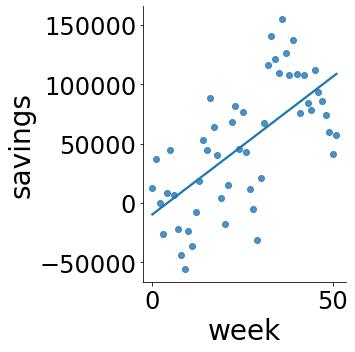

In [78]:
sns.lmplot(x="week", y="savings", data=df2, ci=None); plt.show()

To place the line we minimize the distance of the points to the line, squared.

### Ordinary Least Squares

![alt text](least-squares-regression-line.jpeg "Title")

Visually, we want the sum of the area of these boxes to be as small as possible.

Stated more qualitatively: we're finding the line that minimizes how spread out our data is from the line.

### Slope

The slope (or "steepness") of that line is calulated as:

$$
S = \frac{\sum_{i=1}^{n}{(x_i - \bar{x})(y_i - \bar{y})}}{\sum_{i=1}^{n}{(x_i - \bar{x})}^2}
$$

For our purposes, `S` will represent the number of dollars Emily saves each week, on average.
          

If we apply this formula on Emily's data, we learn that:

1. She's saving an average of \$2321/week
2. It'll take her fewer than 8 years to buy her unicorn, instead of more than 21. 

And that doesn't count of she changes her spending habits!

### y-intercept

To define the line of best fit, you also need to define the "y-intercept", or the value of `y` when `x=0`. Here's the formula in our case:

$$
b = \bar{y} - S\bar{x}
$$

_Note:_ This value doesn't have a particularly meaningful interpretation for our specific word problem, though, it can be useful in other cases. 

### p-value

`p-values` are also applicable to lines of best fit. You can phrase what information a `p-value` tells you a few different ways:

1. The lower the `p-value` the better your line-of-best-fit is at describing the data
2. The lower the `p-value` the more predictive power you have

For Emily's data, we can calculate a `p-value` by:

In [179]:
linregress(df2["week"], df2["savings"]).pvalue

1.2967281822155235e-07

# <span style='color:blue'>  Part 3: Twist </span> 

### A word problem

Erin has invented a new air conditioning device that uses ultra-low power. It cools an Arizona house for a few dollars a month. She has two different designs for the device, and must decide which to commercialize. She runs both designs for a month, measuring their power consumption every hour. Which of the two methods we've learned, a t-test or linear regression, should she use to make her decision?

### Digging a little deeper

In [160]:
a = np.random.normal(100, 20, (30*24))
b = np.random.normal(90, 20, (30*24))
print(ttest_ind(a, b))
dummy = ([0]*(30*24)) + ([1]*(30*24))
ab = list(a) + list(b)
print(linregress(dummy, ab))

Ttest_indResult(statistic=11.080329960842494, pvalue=1.94473286222529e-27)
LinregressResult(slope=-11.531679841992926, intercept=101.34913718055441, rvalue=-0.2804676157547585, pvalue=1.9447328622258202e-27, stderr=1.0407343357775007, intercept_stderr=0.7359103062419482)


In [180]:
def devices():
    sns.histplot(a, color=colors[0], label=f"Design (a)")
    sns.histplot(b, color=colors[1], label=f"Design (b)")
    plt.legend()
    plt.xlabel("Energy consumed")
    plt.show()

In [181]:
devices()

### It is, of course, a trick question

While the problem is worded most similarly to Amber's trail usage problem, we can quickly show that the `p-value` we get from a linear regression is exactly the same, if we encode our data properly.

### Dummy encoding

All we have to do is use linear regression where all of the samples from design `(a)` are assigned a value of `0` for their x variable, and all of the samples from design `(b)` are assigned `1`. This is called "dummy encoding".  

In [171]:
sns.lmplot(x="design", y="power", data=df2, ci=None, aspect=1.5, x_jitter=.05); plt.show()

Tada!

### Results

In [178]:
print(ttest_ind(a, b).pvalue)
print(linregress(dummy, ab).pvalue)

1.94473286222529e-27
1.9447328622258202e-27


# <span style='color:blue'> Summary </span> 

* Averages alone are insufficient to conclude whether our advertising had an effect on trail use. 

* The **average** gives us information about the _peaks_ of these groups. 
* The **variance** gives us information about the _widths_ of these groups.

* When you hypothesize that the averages of two groups of numbers are different or not, the `t-test` may be able to give you a mathematical way to decide.

In [94]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

In [144]:
def variance(x):
    vals = np.random.normal(90, x, (30*24))
    vals2 = np.random.normal(90, 10, (30*24))
    sns.histplot(vals2, color=colors[2])
    sns.histplot(vals, color=colors[1])
    plt.show()
    
w = interact(variance, x=widgets.IntSlider(min=1, max=60, step=1, value=10))

interactive(children=(IntSlider(value=10, description='x', max=60, min=1), Output()), _dom_classes=('widget-in…

In [143]:
def distance(x):
    vals = np.random.normal(0, 20, 100)
    vals2 = np.random.normal(x, 20, 100)
    sns.histplot(vals, color=colors[1])
    sns.histplot(vals2, color=colors[2])
    pvalue = round(ttest_ind(vals, vals2).pvalue, 8)
    plt.title(f"{pvalue=}")
                   
    plt.show()

w = interact(distance, x=widgets.IntSlider(min=1, max=30, step=1, value=1))

interactive(children=(IntSlider(value=1, description='x', max=30, min=1), Output()), _dom_classes=('widget-int…